In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_excel("G:\DCS-SEM 4\Predicitive analysis\Dataset\Superstore.xls")

#  ARIMA Forecasting

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Validation

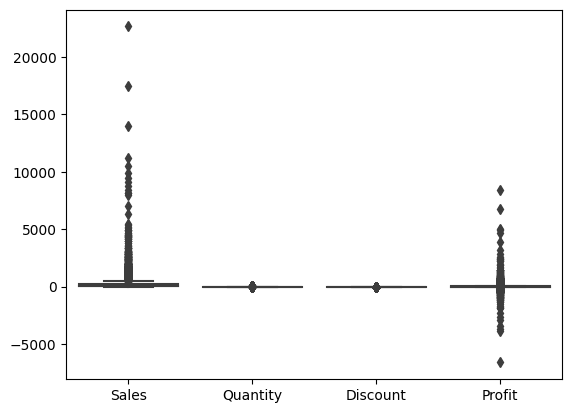

In [4]:
sns.boxplot(df[["Sales", "Quantity", "Discount", "Profit"]])
plt.show()

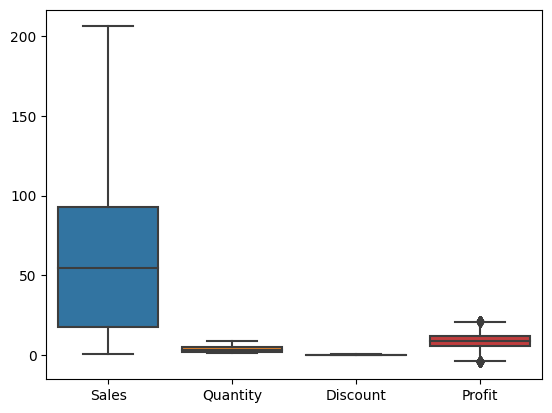

In [24]:
train = df[["Sales", "Quantity", "Discount", "Profit"]]
def impute_outliers(data, column, factor):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    
    data_copy = data.copy()
    data_copy[column] = np.where(data_copy[column] < lower_bound, np.nan, data_copy[column])
    data_copy[column] = np.where(data_copy[column] > upper_bound, np.nan, data_copy[column])
    
    imputer = SimpleImputer(strategy="mean")
    data_imputed = imputer.fit_transform(data_copy)
    
    return pd.DataFrame(data_imputed, columns=data.columns)

for column in ["Sales", "Quantity", "Discount", "Profit"]:
    train = impute_outliers(train, column, 1.5)

df[["Sales", "Quantity", "Discount", "Profit"]] = train
sns.boxplot(train)
plt.show()

In [25]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

df["Order Month"] = df["Order Date"].dt.month
df["Order Year"] = df["Order Date"].dt.year
# Aggregate the sales by month
sales_by_year = df.groupby("Order Year")["Sales"].sum().reset_index()
sales_by_year.head()

,Order Year,Sales
0,2014,111541.479093
1,2015,122390.550501
2,2016,145664.491112
3,2017,187273.702032


### Model Fitting and evaluation

In [26]:
arima_model = ARIMA(sales_by_year["Sales"], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
y_true = sales_by_year["Sales"]
y_pred = arima_model_fit.fittedvalues
print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))

MAE: 36451.31827058106
MSE: 3251419651.182777


### Forecasting

In [27]:
forecast = arima_model_fit.forecast(steps = 5)
print(forecast)

4    212122.119336
5    236969.462072
6    261815.730286
7    286660.924025
8    311505.043335
Name: predicted_mean, dtype: float64


### Plotting of Actual data with Forecasted data

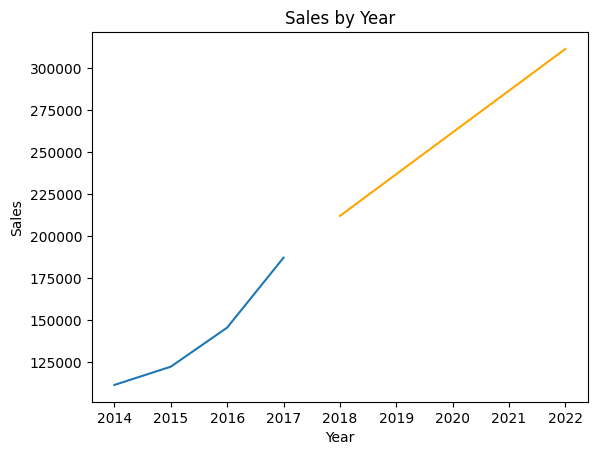

In [28]:
plt.plot(sales_by_year["Order Year"], sales_by_year["Sales"])
plt.plot([2018 , 2019 , 2020 , 2021 , 2022],forecast, color = "orange")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Sales by Year")
plt.show()

# Forecasting for each Category

In [29]:
x = df.groupby([ 'Category' , 'Order Year'])['Sales'].sum().reset_index().pivot(index = 'Order Year' , 
                                                                                columns = 'Category' , values = "Sales")
x.head()

Category,Furniture,Office Supplies,Technology
Order Year,,,
2014,31183.108786,51451.451844,28906.918462
2015,34756.221225,55513.144851,32121.184425
2016,41720.274725,67662.155496,36282.060892
2017,49511.356485,86955.114788,50807.230759


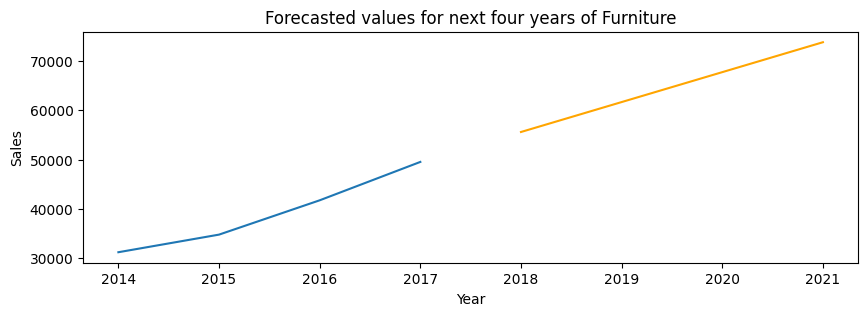

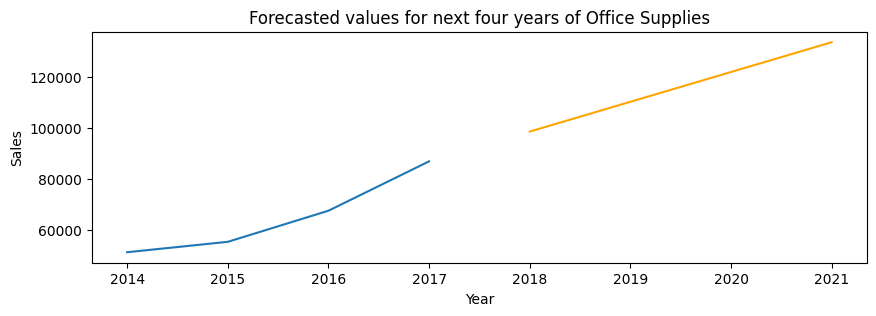

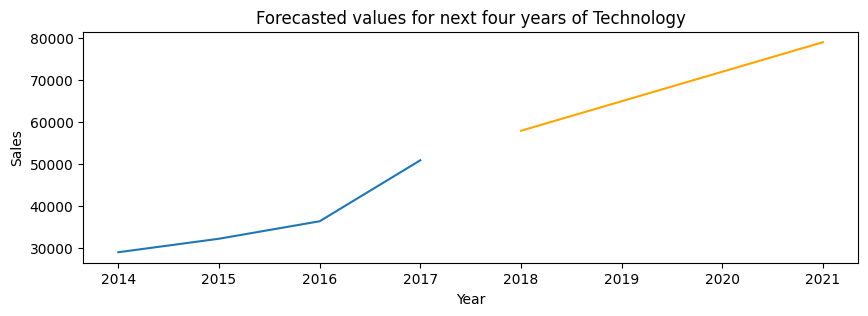

In [30]:
def forecasting(x):
    arima_model = ARIMA(x , order = (1,1,1))
    arima_model_fit= arima_model.fit()
    forecast_values = arima_model_fit.forecast(steps = 4)
    return forecast_values.round(2)

for i in x.columns:
    values = forecasting(x[i])
    plt.figure(figsize = (10, 3))
    plt.plot(x.index,x[i])
    plt.plot([2018 , 2019 , 2020 , 2021] , values , color = 'orange')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.title(f'Forecasted values for next four years of {i}')
    

# Clustering

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [32]:
df_cluster = df.groupby("Customer ID").sum()
train = df_cluster[["Sales", "Quantity", "Discount", "Profit"]]

## Optimal K size
### Elbow Method

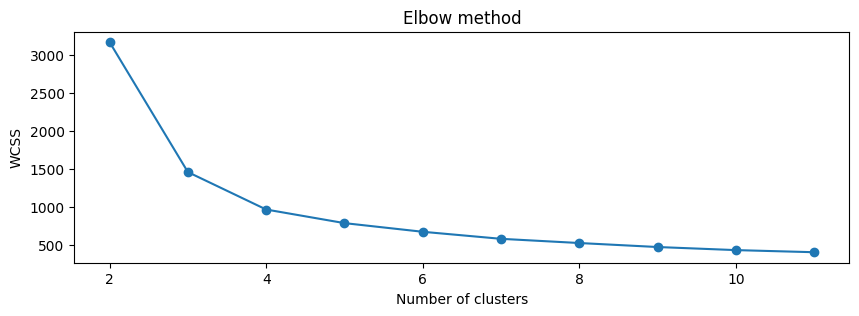

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train)

#Elbow Method
wcss = [] 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42 , n_init = 10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize = (10 ,3))
plt.plot(range(2, 12), wcss, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow method")
plt.show()

### Infrence
We can see that from 2 - 3 the value of WCSS decreasing fast and in a straight but after 2 there is a slow drop and decreasing exponentially so K = 3

## K - Means Algorithim

In [34]:
k_opt = 3 
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42 , n_init = 10)
kmeans_opt.fit(train)

# Assign the cluster labels to the data set
df_cluster["Cluster"] = kmeans_opt.labels_

In [35]:
df_cluster[["Sales", "Quantity", "Discount", "Profit" , "Cluster"]].groupby("Cluster").sum(numeric_only = True)

,Sales,Quantity,Discount,Profit
Cluster,,,,
0,130534.243618,9534.156352,277.169435,21389.762424
1,155063.453112,9148.771987,247.356556,21448.486160
2,281272.526008,17834.236156,509.751297,40655.312978


### Infrence
* Cluster 0 has an average sales value of 130534.24, an average quantity of 9534.16, an average discount of 277.17 and an average profit of 21244.03.
* Cluster 1 has an average sales value of 155063.45, an average quantity of 9148.77, an average discount of 247.36 and an average profit of 21353.37.
* Cluster 2 has an average sales value of 281272.53, an average quantity of 17834.24, an average discount of 509.75 and an average profit of 40649.32.

### Conclusion
Based on these values, Cluster 2 has the highest mean values for sales, quantity, discount and profit. This suggests that customers in Cluster 2 are generating more sales and profit for the supermarket compared to customers in Clusters 0 and 1.

Overall, this analysis suggests that customers in Cluster 2 may be more valuable to the supermarket in terms of generating sales and profit. It may be worth exploring further to understand what differentiates customers in Cluster 2 from those in Clusters 0 and 1 and how the supermarket can attract more customers like those in Cluster 2.


# Classification

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Fitting and Evaluation 

In [37]:
X = df_cluster[["Sales" ,  "Quantity", "Discount", "Profit"]]
y = df_cluster["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
log_reg = LogisticRegression(max_iter = 100000)
log_reg.fit(X_train, y_train)

#Predictions
y_pred = log_reg.predict(X_test)

#Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[70  0  0]
 [ 0 20  0]
 [ 0  0 69]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        69

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159



## Classifiying new rows

In [39]:
def predict(test):
    return log_reg.predict(test)

name          = input('Name:')
sales         = int(input("Sales:"))
quantity      = int(input("Quantity:"))
discount_rate = float(input("Discount:"))
profit        = int(input("Profit:"))

cluster = predict(pd.DataFrame({'Sales' :[sales], 'Quantity' :[quantity] , 'Discount' : [discount_rate] , 'Profit':[profit]}))
print(f'Cusomer {name} belongs to cluster :{cluster[0]}')

Name:Kaviya
Sales:120
Quantity:12
Discount:12
Profit:1
Cusomer Kaviya belongs to cluster :0
